# Week 4: Mapping Demolitions and Affordability in Los Angeles
This notebook explores the spatial distribution of RSO demolitions in Los Angeles and their relationship to rent changes and affordability.

In [1]:
# Import necessary libraries
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point


## Load and Process Demolition Permit Data

This step adds code to fetch data from the LA Demolition Permit API, cleans lat/long data, and geocodes them.

In [2]:
# API URL for demolition permits
url = "https://data.lacity.org/resource/fsgi-y87k.json"

# Fetch data from API
response = requests.get(url)
demo_data = pd.DataFrame(response.json())

# Print all column names to understand available data
print("Columns in demolition dataset:", demo_data.columns)

Columns in demolition dataset: Index(['assessor_book', 'assessor_page', 'assessor_parcel', 'tract', 'lot',
       'reference_old_permit', 'pcis_permit', 'latest_status', 'status_date',
       'permit_type', 'permit_sub_type', 'permit_category',
       'initiating_office', 'issue_date', 'address_start', 'address_end',
       'street_direction', 'street_name', 'street_suffix', 'zip_code',
       'work_description', 'valuation', 'contractors_business_name',
       'contractor_address', 'contractor_city', 'contractor_state',
       'license_type', 'license', 'principal_first_name',
       'principal_middle_name', 'principal_last_name',
       'license_expiration_date', 'applicant_first_name',
       'applicant_last_name', 'zone',
       'floor_area_l_a_building_code_definition', 'census_tract', 'location_1',
       'floor_area_l_a_zoning_code_definition',
       'of_residential_dwelling_units', 'block', 'of_stories',
       'applicant_business_name', 'applicant_address_1', 'applicant_addre

## Clean the Latitude and Longitude Data

The demolitions permits need latitude and longitude conversion into separate columns.

In [3]:
# Extract coordinates safely
def extract_coordinates(location):
    if isinstance(location, dict) and "coordinates" in location:
        try:
            return location["coordinates"][0], location["coordinates"][1]
        except (IndexError, TypeError):
            return None, None
    return None, None

demo_data[["longitude", "latitude"]] = demo_data["location_1"].apply(
    lambda x: pd.Series(extract_coordinates(x))
)

# Check results
demo_data[["longitude", "latitude"]].head()


,longitude,latitude
0,-118.41259,34.02224
1,-118.49970,34.06234
2,-118.40424,33.99961
3,-118.50359,34.16005
4,-118.42087,34.14943


In [4]:
# Create geometry column from extracted coordinates
demo_data["geometry"] = demo_data.apply(lambda row: Point(row["longitude"], row["latitude"]) if pd.notnull(row["longitude"]) else None, axis=1)

# Convert to GeoDataFrame
demo_gdf = gpd.GeoDataFrame(demo_data, geometry="geometry", crs="EPSG:4326")  # Set WGS84 CRS

In [5]:
# Display the first few rows
demo_gdf.head()

,assessor_book,assessor_page,assessor_parcel,tract,lot,reference_old_permit,pcis_permit,latest_status,status_date,permit_type,...,applicant_address_2,applicant_address_3,address_fraction_end,occupancy,address_fraction_start,unit_range_start,unit_range_end,longitude,latitude,geometry
0,4252,035,017,TR 7265,56,23LA03288,22019-30000-00362,Issued,2023-05-18T00:00:00.000,Bldg-Demolition,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-118.41259,34.02224,POINT (-118.41259 34.02224)
1,4425,022,004,TR 14038,4,23WL01286,23019-30000-01656,Issued,2023-05-18T00:00:00.000,Bldg-Demolition,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-118.49970,34.06234,POINT (-118.4997 34.06234)
2,4215,031,002,TR 1441,14,23WL01271,23019-30000-00410,Issued,2023-05-17T00:00:00.000,Bldg-Demolition,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-118.40424,33.99961,POINT (-118.40424 33.99961)
3,2258,013,002,ENCINO TRACT,5,23ON 0807,23019-30000-01137,Issued,2023-05-12T00:00:00.000,Bldg-Demolition,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-118.50359,34.16005,POINT (-118.50359 34.16005)
4,2375,001,075,TR 7730,57,23VN03655,23019-30000-01594,Issued,2023-05-12T00:00:00.000,Bldg-Demolition,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-118.42087,34.14943,POINT (-118.42087 34.14943)


## Load Ellis Act Application Data
Load Ellis Act Application data to see RSOs that have been taken off the market, and merge with demolition data to see how many of them have been taken off the market to demolish.

In [6]:
# Upload Ellis data
ellis_data = pd.read_csv("data/updated_rso_data.csv")
ellis_data.head()

,APN,Application Received,Application Year,Council District,Address,City,Zip,Units Withdrawn,Replacement Unit,Latitude,Longitude
0,2040031029,11/6/2019,2019,3,22729 W DEL VALLE ST,LOS ANGELES,91364.0,3.0,NaN,34.165795,-118.621248
1,2040031030,12/4/2019,2019,3,22727 W DEL VALLE ST,WOODLAND HILLS,91364.0,3.0,NaN,34.165958,-118.621237
2,2040031050,2/25/2016,2016,3,22769 W DEL VALLE ST,LOS ANGELES,91364.0,2.0,22.0,34.165508,-118.622696
3,2040033033,2/10/2016,2016,3,22431 W DEL VALLE ST,WOODLAND HILLS,91364.0,3.0,NaN,34.167418,-118.616607
4,2107011026,6/29/2023,2023,3,20137 W ARMINTA ST,LOS ANGELES,91306.0,2.0,NaN,34.213476,-118.422740


In [7]:
# Finding all blank Council Districts 
ellis_data[ellis_data['Council District']==99]

,APN,Application Received,Application Year,Council District,Address,City,Zip,Units Withdrawn,Replacement Unit,Latitude,Longitude
814,4259014019,7/10/2017,2017,99,1737 S WESTGATE AVE,LOS ANGELES,90025.0,3.0,NaN,34.038607,-118.45624


In [8]:
# Drop blank data rows
rows_to_drop = ellis_data[ellis_data['Council District'] == 99].index
ellis_data.drop(rows_to_drop, inplace=True)

# Check how many rows were dropped
print(f"Rows dropped: {len(rows_to_drop)}")
print(f"Ellis data remaining: {len(ellis_data)}")


Rows dropped: 1
Ellis data remaining: 3358


In [9]:
# Keep Ellis Applications after 2013 to match demolition data
ellis_data["Application Year"] = pd.to_numeric(ellis_data["Application Year"], errors="coerce")
ellis_data = ellis_data[ellis_data["Application Year"] >= 2013]

In [10]:
# check for any other missing values from dataset
print(ellis_data.isnull().sum())  # Check missing values
print(demo_data.isnull().sum())  # Check missing values

APN                        0
Application Received       0
Application Year           0
Council District           0
Address                    0
City                       0
Zip                        0
Units Withdrawn            1
Replacement Unit        2447
Latitude                   1
Longitude                  1
dtype: int64
assessor_book                                0
assessor_page                                0
assessor_parcel                              0
tract                                        1
lot                                          3
reference_old_permit                         0
pcis_permit                                  0
latest_status                                0
status_date                                  0
permit_type                                  0
permit_sub_type                              0
permit_category                              0
initiating_office                            0
issue_date                                   0
address_st

In [11]:
# Convert Ellis Act Data to GeoDataFrame
ellis_data["geometry"] = ellis_data.apply(lambda row: Point(row["Longitude"], row["Latitude"]) if pd.notnull(row["Longitude"]) else None, axis=1)
ellis_gdf = gpd.GeoDataFrame(ellis_data, geometry="geometry", crs="EPSG:4326")  # Set WGS84 CRS

In [12]:
# Reproject to a Metric CRS (California Albers - EPSG:3310)
projected_crs = "EPSG:3310"  # California Albers for accurate distance calculations

# Reproject both datasets correctly
demo_gdf = demo_gdf.to_crs(projected_crs)
ellis_gdf = ellis_gdf.to_crs(projected_crs)


In [13]:
# Verify CRS transformation
print(f"Demolition CRS: {demo_gdf.crs}, Ellis CRS: {ellis_gdf.crs}")

# Check projected geometries
print(demo_gdf[["geometry"]].head())  
print(ellis_gdf[["geometry"]].head())


Demolition CRS: EPSG:3310, Ellis CRS: EPSG:3310
                         geometry
0  POINT (146604.552 -442472.577)
1  POINT (138489.952 -438156.086)
2  POINT (147417.879 -444969.451)
3   POINT (137959.761 -427323.59)
4  POINT (145604.913 -428377.851)
                         geometry
0  POINT (127103.907 -426850.744)
1  POINT (127104.676 -426832.625)
2  POINT (126970.945 -426884.465)
3  POINT (127529.155 -426664.406)
4  POINT (145314.249 -421276.213)


In [14]:
# Ensure CRS is correctly projected
if demo_gdf.crs != "EPSG:3310":
    demo_gdf = demo_gdf.to_crs("EPSG:3310")
if ellis_gdf.crs != "EPSG:3310":
    ellis_gdf = ellis_gdf.to_crs("EPSG:3310")

print(f"Updated CRS - Demolitions: {demo_gdf.crs}, Ellis: {ellis_gdf.crs}")


Updated CRS - Demolitions: EPSG:3310, Ellis: EPSG:3310


## Spatial Analysis
To assess how many demolitions occur near Ellis Act removals, perform a spatial join/buffer analysis.  This section will do this by join demolition permits to Ellis Act Cases within a 500 meter buffer.

In [15]:
# Check for Missing Geometries
print(f"Missing geometries in Ellis Act Data: {ellis_gdf['geometry'].isnull().sum()}")
print(f"Missing geometries in Demolitions Data: {demo_gdf['geometry'].isnull().sum()}")

Missing geometries in Ellis Act Data: 1
Missing geometries in Demolitions Data: 26


In [16]:
# Drop missing geometries 
ellis_gdf = ellis_gdf[ellis_gdf["geometry"].notnull()]
demo_gdf = demo_gdf[demo_gdf["geometry"].notnull()]

In [17]:
# Create buffer (500m)
ellis_gdf["buffer"] = ellis_gdf.geometry.buffer(500)

# Convert to geodataframe for spatial join
ellis_buffer_gdf = gpd.GeoDataFrame(ellis_gdf, geometry="buffer", crs="EPSG:3310")

# Check buffer validity
print(f"Total buffers created: {len(ellis_buffer_gdf)}")
print(ellis_buffer_gdf.head())


Total buffers created: 3152
          APN Application Received  Application Year  Council District  \
0  2040031029            11/6/2019              2019                 3   
1  2040031030            12/4/2019              2019                 3   
2  2040031050            2/25/2016              2016                 3   
3  2040033033            2/10/2016              2016                 3   
4  2107011026            6/29/2023              2023                 3   

                Address             City      Zip  Units Withdrawn  \
0  22729 W DEL VALLE ST     LOS ANGELES   91364.0              3.0   
1  22727 W DEL VALLE ST  WOODLAND HILLS   91364.0              3.0   
2  22769 W DEL VALLE ST     LOS ANGELES   91364.0              2.0   
3  22431 W DEL VALLE ST  WOODLAND HILLS   91364.0              3.0   
4    20137 W ARMINTA ST     LOS ANGELES   91306.0              2.0   

   Replacement Unit   Latitude   Longitude                        geometry  \
0               NaN  34.1657

In [18]:
# Number of demolitions near Ellis Act buffer 
demo_near_ellis = gpd.sjoin(demo_gdf, ellis_buffer_gdf, predicate="intersects", how="inner")

print(f"Number of demolitions near Ellis Act removals (buffer method): {len(demo_near_ellis)}")


Number of demolitions near Ellis Act removals (buffer method): 6946


In [19]:
# Check for overlapping clusters in the buffers
demo_near_ellis = gpd.sjoin(demo_gdf, ellis_buffer_gdf, predicate="intersects", how="inner")



In [20]:
# Remove duplicate demolitions that fall into multiple buffers
demo_near_ellis = demo_near_ellis.drop_duplicates(subset=["geometry"])

print(f"Demolitions within 500m buffer (after deduplication): {len(demo_near_ellis)}")


Demolitions within 500m buffer (after deduplication): 634


In [21]:
from shapely.ops import nearest_points

# Define the function correctly
def find_nearest_ellis(row, ellis_gdf):
    if row.geometry is None or ellis_gdf.geometry.is_empty.any():
        return None  # Skip rows with missing geometry

    # Use `union_all()` instead of `unary_union`
    ellis_union = ellis_gdf.geometry.union_all()
    
    if ellis_union.is_empty:
        return None  # If all geometries in ellis_gdf are empty, return None

    nearest_geom = nearest_points(row.geometry, ellis_union)[1]
    return row.geometry.distance(nearest_geom)

In [22]:
# Try another method, seeing how many demolitions are near Ellis Act Applications
demo_gdf.loc[:, "distance_to_ellis"] = demo_gdf.apply(
    lambda row: find_nearest_ellis(row, ellis_gdf), axis=1
)

print(demo_gdf[["distance_to_ellis"]].head(10))  # Check the first 10 rows

   distance_to_ellis
0          74.835633
1        2128.944863
2         119.263204
3        2245.791511
4         135.508429
5         601.549787
6         169.181963
7          62.403702
8        1089.058461
9         134.655321


In [23]:
# check for missing values
print(demo_gdf["distance_to_ellis"].isnull().sum())  # Count null values


0


In [24]:
# Revuew distribution of distances
print(f"Min Distance: {demo_gdf['distance_to_ellis'].min()} meters")
print(f"Max Distance: {demo_gdf['distance_to_ellis'].max()} meters")
print(f"Mean Distance: {demo_gdf['distance_to_ellis'].mean()} meters")


Min Distance: 0.0 meters
Max Distance: 5362.794087386685 meters
Mean Distance: 472.3517487379432 meters


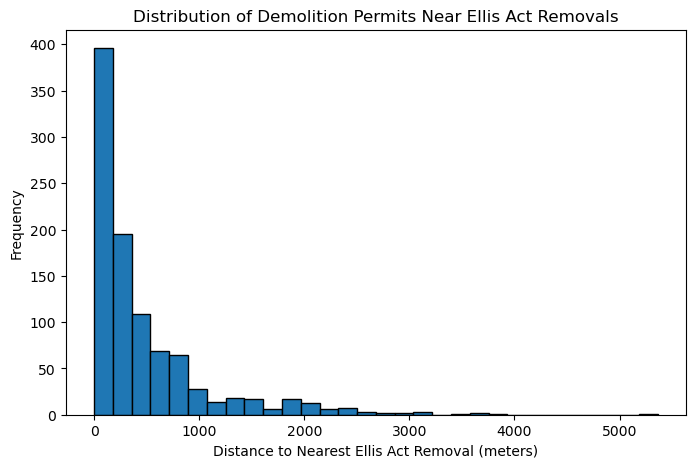

In [25]:
# Plot a histogram to check how distances are distributed
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(demo_gdf["distance_to_ellis"].dropna(), bins=30, edgecolor="black")
plt.xlabel("Distance to Nearest Ellis Act Removal (meters)")
plt.ylabel("Frequency")
plt.title("Distribution of Demolition Permits Near Ellis Act Removals")
plt.show()


In [26]:
# Compare the two methods of spatial analysis

buffer_count = len(demo_near_ellis)  # From buffer method
distance_count = len(demo_gdf[demo_gdf["distance_to_ellis"] <= 500])  # From distance method

print(f"Demolitions within 500m buffer: {buffer_count}")
print(f"Demolitions within 500m distance: {distance_count}")


Demolitions within 500m buffer: 634
Demolitions within 500m distance: 685


In [35]:
import folium
import requests
import geopandas as gpd
from folium import GeoJson

# Fetch City Council District Boundaries
url = "https://maps.lacity.org/lahub/rest/services/Boundaries/MapServer/13/query?outFields=*&where=1%3D1&f=geojson"
response = requests.get(url)
council_districts = gpd.read_file(response.text)

# Ensure CRS is the same for all GeoDataFrames
council_districts = council_districts.to_crs("EPSG:4326")
demo_near_ellis = demo_near_ellis.to_crs("EPSG:4326")

# Calculate the center of the map based on the geometries
center_lat = demo_near_ellis.geometry.y.mean()
center_lon = demo_near_ellis.geometry.x.mean()

# Create a folium map centered around the calculated center
m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Add City Council District Boundaries to the map
GeoJson(council_districts).add_to(m)

# Add Demolitions within 500m buffer to the map with tooltips
for idx, row in demo_near_ellis.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6,
        tooltip=row['address'] if 'address' in row else 'Demolition Site'
    ).add_to(m)

# Display the map
m

# Save the map as an HTML file
m.save("Demolitions_Ellis_Buffer.html")


In [36]:
import folium
from folium.plugins import HeatMap

# Calculate the center of the map based on the geometries
center_lat = demo_near_ellis.geometry.y.mean()
center_lon = demo_near_ellis.geometry.x.mean()

# Create a folium map centered around the calculated center
m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Add City Council District Boundaries to the map
GeoJson(council_districts).add_to(m)

# Prepare data for HeatMap
heat_data = [[row.geometry.y, row.geometry.x] for idx, row in demo_near_ellis.iterrows()]

# Add HeatMap to the map
HeatMap(heat_data).add_to(m)

# Add a title to the map
title_html = '''
             <h3 align="center" style="font-size:20px"><b>Demolition Density within Ellis Act Buffer in Los Angeles</b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))

# Display the map
m
# Save the map as an HTML file
m.save("Choropleth_Demolitions_Ellis_Buffers.html")
